# Takeda: Iterative Keyword Search

### Utility functions to interact with PubMed

In [1]:
import sys
sys.path.append('.')

In [2]:
from nltk import word_tokenize
import pandas as pd
from utils import get_extractor
from pubmed import search, fetch_details, construct_query

In [3]:
# Config Keyword Extractors
config = {
    'lan': 'en',
    'n': 3,
    'dedupLim': 0.9,
    'dedupFunc': 'seqm',
    'windowsSize': 1,
    'top': 100,
    'features': None
}

config_100 = {**config}
kwe_100 = get_extractor(top=100)
kwe_20 = get_extractor(top=20)

#### Interactive Accept/Reject papers flow

In [4]:
from ipywidgets import Button, HBox, VBox, HTML, Layout, widgets
import asyncio
from IPython.display import display, clear_output

def get_decisions(papers, top_paper_idxs, decisions):
        def wait_for_change(widget1, widget2):
            future = asyncio.Future()
            def getvalue(change):
                future.set_result(change.description)
                widget1.on_click(getvalue, remove=True)
                widget2.on_click(getvalue, remove=True)
            widget1.on_click(getvalue)
            widget2.on_click(getvalue)
            return future
        
        
        button1=Button(description="Relevant")
        button2=Button(description="Not Relevant")
        text_box = widgets.HTML(
            value="placeholder",
        )
        
        hbox = HBox([button1,button2])
        vbox = VBox([text_box, hbox], layout=Layout(border='solid'))
        
        
        def update_textbox(paper):
            text_value = f'<b>title</b>: {paper["title"]} <br><hr> <b>abstract</b>: {paper["abstract"]}<hr>'
            text_box.value = text_value
            display(vbox)
        
        async def get_paper_decisions(papers, paper_idxs):
            chosen_papers = papers.iloc[paper_idxs]
        
            for j, paper in chosen_papers.iterrows():
                update_textbox(paper)
                res = await wait_for_change(button1, button2)
                decisions.append(res)
                print(res)
                print()
            vbox.close()
            
            for j, d in enumerate(decisions):
                decisions[j] = d == 'Relevant'
                
        
        display(vbox)
        asyncio.create_task(get_paper_decisions(papers, top_paper_idxs))
        
        return ''

### Proof of concept run

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re

In [6]:
# query 1
query = [('refactory', 'relapsed'), 'multiple myeloma', 'bortezomib']
query_str = construct_query(query)

In [7]:
# query 2
query = [('refactory', 'relapsed'), 'multiple myeloma', 'bortezomib', ('PFS', 'OS', 'ORR', 'PR', 'VGPR', 'TNT', 'TTP')]
query_str = construct_query(query)

In [8]:
# Fetch 100 papers
print('Search query:', query_str)
query_res = search(query_str, retmax=100)
id_list = query_res['IdList']
query_res = fetch_details(id_list)

Search query: (((refactory[Title/Abstract]) OR (relapsed[Title/Abstract])) AND (multiple myeloma[Title/Abstract]) AND (bortezomib[Title/Abstract]) AND ((PFS[Title/Abstract]) OR (OS[Title/Abstract]) OR (ORR[Title/Abstract]) OR (PR[Title/Abstract]) OR (VGPR[Title/Abstract]) OR (TNT[Title/Abstract]) OR (TTP[Title/Abstract])))


In [9]:
# Get most relevant keywords
papers = pd.DataFrame(query_res)

In [10]:
# get list of embedded keywords
# only keep those that appear in at least min_doc_freq fraction of documents
min_doc_freq = 0.02

keywords = set()
keywords_freq = {}
for j, row in papers.iterrows():
    for kw in row['keywords']:
        if kw not in keywords_freq:
            keywords_freq[kw] = 0
        keywords_freq[kw] += 1
kw_df = pd.DataFrame(keywords_freq.items(), columns=['keyword', 'count']).sort_values('count', ascending=False)
kw_df['freq'] = kw_df['count']/len(kw_df)
min_freq_mask = kw_df['freq'] >= min_doc_freq
embedded_kws = kw_df.loc[min_freq_mask]['keyword'].values.tolist()
print('Kept embedded keywords:')
print(embedded_kws)

Kept embedded keywords:
['multiple myeloma', 'Multiple myeloma', 'bortezomib', 'pomalidomide', 'dexamethasone', 'daratumumab', 'Efficacy', 'Daratumumab', 'lenalidomide', 'Bortezomib', 'ixazomib', 'Proteasome inhibitor', 'refractory', 'real-world', 'relapse', 'carfilzomib']


In [11]:
# Get keywords from document title/abstract
all_text = papers['title'] + ' ' + papers['abstract'] # most papers don't have abstracts
# all_text = papers['title']
papers['text'] = all_text
all_text = re.sub('\s+', ' ', ' '.join(all_text)).strip()
yake_kws = list(map(lambda e: e[0], kwe_100.extract_keywords(all_text)))
print('Yake  keywords:')
print(yake_kws)

Yake  keywords:
['refractory multiple myeloma', 'multiple myeloma', 'relapsed multiple myeloma', 'refractory multiple', 'patients', 'median PFS', 'PFS', 'bortezomib', 'myeloma', 'multiple', 'refractory', 'relapsed', 'relapsed refractory multiple', 'RRMM patients', 'multiple myeloma patients', 'dexamethasone', 'RRMM', 'months', 'patients with relapsed', 'relapsed multiple', 'median', 'treatment', 'response', 'response rate', 'ORR', 'Median progression-free survival', 'progression-free survival', 'survival', 'relapsed or refractory', 'patients with RRMM', 'refractory patients', 'lenalidomide', 'therapy', 'combination', 'patients received', 'prior', 'prior bortezomib', 'study', 'refractory myeloma', 'phase', 'safety', 'myeloma patients', 'rate', 'multiple myeloma refractory', 'adverse events', 'Efficacy', 'Bortezomib and Dexamethasone', 'received prior bortezomib', 'phase III trials', 'low-dose dexamethasone', 'relapsed refractory', 'phase III', 'trials', 'partial response', 'Median progr

### Combine embedded and yake keywords

In [13]:
max_keywords = 100

used_keywords = set()
keywords = []

for kw in embedded_kws:
    if len(keywords) >= max_keywords:
        break
    
    if kw.lower() not in used_keywords:
        keywords.append(kw.lower())
        used_keywords.add(kw.lower())

for kw in yake_kws:
    if len(keywords) >= max_keywords:
        break
    
    if kw.lower() not in used_keywords:
        keywords.append(kw.lower())
        used_keywords.add(kw.lower())

# Construct Karnaugh Map
kw_karnaugh_map = np.zeros((len(papers), len(keywords)))
for kw_idx, kw in enumerate(keywords):
    kw_mask = papers['text'].apply(lambda s: kw in s)
    kw_karnaugh_map[:, kw_idx] = kw_mask
    
# Filter uninformative keywords
min_idf = 0.1
max_idf = 0.9

kw_means = kw_karnaugh_map.mean(axis=0)
keep_idxs = np.where( (min_idf <= kw_means) & (kw_means <= 0.9) )[0]
keywords = np.array(keywords)[keep_idxs]
kw_karnaugh_map = kw_karnaugh_map[:, keep_idxs]

### Cluster Documents

Idea: Cluster documents based on PCA of karnaugh map. Label each cluster with whether or not those documents should be included in the review. 

In [14]:
# Normalize data to mean=0 and var=1
means = kw_karnaugh_map.mean(axis=0)
stds = kw_karnaugh_map.std(axis=0)
std_data = (kw_karnaugh_map - means)
std_data /= stds

In [15]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

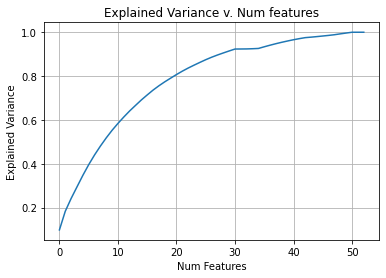

In [16]:
covariance_matrix = np.cov(std_data.T)
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
eigen_values = eigen_values.real
eigen_vectors = eigen_vectors.real

explained_variance = eigen_values/eigen_values.sum()
cumm_variance = explained_variance
for j in range(1, len(explained_variance)):
    cumm_variance[j] += explained_variance[j - 1]
    
sns.lineplot(x=np.arange(len(cumm_variance)), y=cumm_variance)
plt.title('Explained Variance v. Num features')
plt.xlabel('Num Features')
plt.ylabel('Explained Variance')
plt.grid(True)

plt.show()

In [17]:
# Choose number of features
explained_variance_threshold = 0.85
num_features = np.where(cumm_variance >= explained_variance_threshold)[0][1]
projection_matrix = (eigen_vectors.T[:][:num_features]).T
data_pca = std_data.dot(projection_matrix)
print('Number of features:', num_features)

Number of features: 25


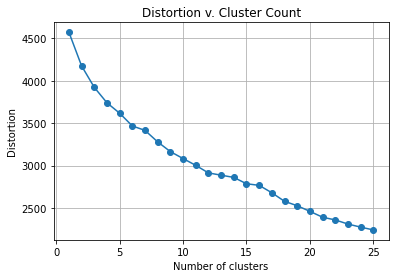

In [19]:
from sklearn.cluster import KMeans

distortions = []
max_clusters = 25
for i in range(1, max_clusters + 1):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(data_pca)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, max_clusters + 1), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Distortion v. Cluster Count')
plt.grid(True)
plt.show()

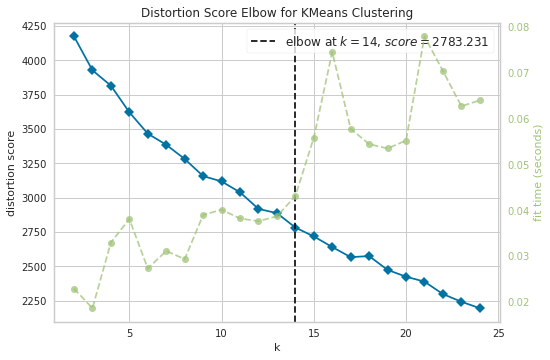

In [29]:
from yellowbrick.cluster.elbow import kelbow_visualizer
res = kelbow_visualizer(KMeans(random_state=4), data_pca, k=(2,25))

In [31]:
'''
Pick number of clusters using Elbow method

-- Data does not seem to cluster too well ^^
'''
cluster_count = 14
km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
km.fit(data_pca)
class_preds = km.predict(data_pca)
cluster_ids, cluster_counts = np.unique(class_preds, return_counts=True)

In [32]:
# get largest clusters
max_shown_clusters = min(20, cluster_count)
count_order = np.argsort(cluster_counts)[::-1]
shown_cluster_idxs = cluster_ids[count_order][:max_shown_clusters]
shown_cluster_counts = cluster_counts[count_order][:max_shown_clusters]

In [33]:
# get representative papers for each cluster
cluster_reprs_paper_idxs = []
for cid in shown_cluster_idxs:
    ridx = np.where(class_preds == cid)[0][0]
    cluster_reprs_paper_idxs.append(ridx)

### Save queries for manual annotation

In [ ]:
import os

In [300]:
# papers #1
query1_df = papers.iloc[cluster_reprs_paper_idxs].copy()
query1_df['relevant'] = False
query_output_dir = '/data/rsg/nlp/juanmoo1/projects/02_iterative_search'
query_1_sheet_path = os.path.join(query_output_dir, 'query_1.xlsx')
# query1_df.to_excel(query_1_sheet_path)

In [318]:
# papers #2
query2_df = papers.iloc[cluster_reprs_paper_idxs].copy()
query2_df['relevant'] = False

query_output_dir = '/data/rsg/nlp/juanmoo1/projects/02_iterative_search'
query_2_sheet_path = os.path.join(query_output_dir, 'query_2.xlsx')
# query2_df.to_excel(query_2_sheet_path)

## Interactively get decisions for each document cluster

In [36]:
decisions = []
res = get_decisions(papers, cluster_reprs_paper_idxs, decisions)

In [37]:
# Label classes and papers that belong to those classes
class_idx_to_decision = {cidx:d for cidx, d in zip(shown_cluster_idxs, decisions)}

papers['pred_class'] = class_preds
papers['used'] = papers['pred_class'].isin(shown_cluster_idxs)
papers['decision'] = np.nan
used_loc = papers['used'] == True
papers.loc[used_loc, 'decision'] = papers.loc[used_loc, 'pred_class'].apply(class_idx_to_decision.get)

In [38]:
used_papers = papers.loc[used_loc]

In [39]:
# Get keywords that are either always or never included on given cluster 

pos_include_kw = set()
pos_noinclude_kw = set()

neg_include_kw = set()
neg_noinclude_kw = set()

for pred_class in pd.unique(used_papers['pred_class']):
    
    class_df = used_papers.loc[used_papers['pred_class'] == pred_class]
    paper_idxs = list(class_df.index)
    print(paper_idxs)
    class_kwm = kw_karnaugh_map[paper_idxs]
    pos_kw = np.where(class_kwm.mean(axis=0) >= 0.999)[0]
    neg_kw = np.where(class_kwm.mean(axis=0) <= 0.001)[0]
    
    print('Class Decision:', class_idx_to_decision[pred_class])
    print('Included Keywords:', keywords[pos_kw])
    print('Not Included Keywords:', keywords[neg_kw])
    
    if class_idx_to_decision[pred_class]:
        pos_include_kw |= set(pos_kw)
        pos_noinclude_kw |= set(neg_kw)
    else:
        neg_include_kw |= set(pos_kw)
        neg_noinclude_kw |= set(neg_kw)
    
    
    print('-' * 10)

[0, 10, 13, 26, 32, 40, 43, 60, 72, 75, 77]
Class Decision: False
Included Keywords: ['refractory' 'refractory multiple myeloma' 'refractory multiple'
 'response' 'response rate' 'progression-free survival' 'survival'
 'therapy' 'prior' 'rate' 'grade' 'progression-free' 'events']
Not Included Keywords: ['ixazomib' 'relapsed multiple myeloma' 'relapsed multiple'
 'relapsed and refractory']
----------
[1, 11, 59, 93]
Class Decision: True
Included Keywords: ['pomalidomide' 'lenalidomide' 'refractory' 'carfilzomib' 'treatment'
 'survival' 'trials' 'trial']
Not Included Keywords: ['real-world' 'relapsed multiple myeloma' 'patients with relapsed'
 'relapsed multiple' 'relapsed or refractory' 'refractory patients'
 'safety' 'bortezomib and dexamethasone' 'low-dose dexamethasone'
 'partial response' 'received' 'grade' 'complete response' 'group'
 'good partial response' 'prior lines' 'cycles' 'median follow-up'
 'efficacy and safety']
----------
[3, 38, 49]
Class Decision: False
Included Keywo

In [40]:
# Show keywords that are included in positive examples that are not included in any negative examples
print('Positive include')
idxs = (pos_include_kw - neg_include_kw)
print([keywords[j] for j in idxs])

print()
# Show keywords that are not included in positive examples that are included in some negative examples
print('Positive no include')
idxs = pos_noinclude_kw - neg_include_kw
print([keywords[j] for j in idxs])

Positive include
['pomalidomide', 'bortezomib and dexamethasone', 'trials']

Positive no include
['pomalidomide', 'ixazomib', 'proteasome inhibitor', 'real-world', 'relapsed or refractory', 'refractory patients', 'bortezomib and dexamethasone', 'low-dose dexamethasone', 'trials', 'partial response', 'complete response', 'relapsed and refractory', 'group', 'good partial response', 'prior lines', 'regimens', 'median follow-up', 'rates', 'efficacy and safety']
